In [1]:
from fastcore.all import *
from fastai.vision.all import *
from fastxtend.audio.all import *
from fastxtend.vision.all import *
from dataclasses import dataclass, field
import pandas as pd
import numpy as np
import time
import os

from torchinfo import summary

T = TypeVar('T')
Listified = Union[T, Iterable[T], MutableSequence[T], L, fastuple]

In [2]:
class EarlyStoppingWithWarmup(TrackerCallback):
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    order=TrackerCallback.order+3
    def __init__(self, 
        monitor='valid_loss', # value (usually loss or metric) being monitored.
        comp=None, # numpy comparison operator; np.less if monitor is loss, np.greater if monitor is metric.
        min_delta=0., # minimum delta between the last monitor value and the best monitor value.
        patience=1, # number of epochs to wait when training has not improved model.
        warmup=5,
        reset_on_fit=True # before model fitting, reset value being monitored to -infinity (if monitor is metric) or +infinity (if monitor is loss).
    ):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        self.patience = patience
        self.warmup = warmup

    def before_fit(self): 
        self.wait = 0
        self.warmup_wait = self.warmup
        super().before_fit()
    def after_epoch(self):
        "Compare the value monitored to its best score and maybe stop training."
        super().after_epoch()
        self.warmup_wait = max(0, self.warmup_wait - 1)
        if self.new_best: self.wait = 0
        else:
            if self.warmup_wait == 0:
                self.wait += 1
            if self.wait >= self.patience and self.warmup_wait == 0:
                print(f'No improvement since epoch {self.epoch - self.wait - (self.warmup - self.warmup_wait)}: early stopping')
                raise CancelFitException()

def save_model(learn, name, pickle=False):
    timestr = time.strftime("%m-%d-%Y")
    file_name = timestr + "/" + name
    os.makedirs("models/" + timestr, exist_ok=True)
    saved = learn.save(file_name)
    learn.save("latest")
    torch.save(learn.model, "checkpoints/latest.pt", )
    if pickle:
        os.makedirs("checkpoints/" + timestr, exist_ok=True)
        learn.export("checkpoints/" + file_name + ".pkl")
        learn.export("checkpoints/latest.pkl")
    return saved, file_name

class SaveBestState(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    order = TrackerCallback.order+1
    def __init__(self, 
        monitor='valid_loss', # value (usually loss or metric) being monitored.
        comp=None, # numpy comparison operator; np.less if monitor is loss, np.greater if monitor is metric.
        min_delta=0., # minimum delta between the last monitor value and the best monitor value.
        fname='model', # model name to be used when saving model.
        every_epoch=False, # if true, save model after every epoch; else save only when model is better than existing best.
        at_end=False, # if true, save model when training ends; else load best model if there is only one saved model.
        with_opt=False, # if true, save optimizer state (if any available) when saving model. 
        reset_on_fit=True # before model fitting, reset value being monitored to -infinity (if monitor is metric) or +infinity (if monitor is loss).
    ):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        self.last_saved_names = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path, self.last_saved_name = save_model(self.learn, name)

    def _load_last(self):  self.learn.load(f'{self.fname}', with_opt=self.with_opt)
    
    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch:
            if (self.epoch%self.every_epoch) == 0: self._save(self.fname)
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')
                print(f'Saved Path: {self.last_saved_path} Saved Name: {self.last_saved_name}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.last_saved_name}', with_opt=self.with_opt)

In [3]:
def binary_acc(yhat, y):
    y,y_pred = TensorBase(y), TensorBase(yhat)
    
    threshold = .5
    
    classes = int(y.shape[2] / 3)
    
    binary_true = torch.stack([y[:, :, x*3] for x in range(classes)], axis=1)
    binary_pred = torch.stack([y_pred[:, :, x*3] for x in range(classes)], axis=1)
    
    binary_true = torch.greater_equal(binary_true, threshold)
    binary_pred = torch.greater_equal(binary_pred, threshold)
    
    acc = (binary_true == binary_pred).type(torch.float32)
    acc = torch.mean(acc, (-1, -2, -3))
    
    return acc

def YOHOLoss(y_pred, y, beta=1.0):
    #beta changes how much of the regression loss counts
    # (bs, 30, 9) tensor shape
    y,y_pred = TensorBase(y), TensorBase(y_pred)
    
    classes = int(y.shape[2] / 3)
    
    squared_diff = torch.square(y_pred - y) 
    
    stack = []
    for c in range(classes):
        ss0 = squared_diff[:, :, c*3] * 0 + 1 #all 1s for binary label squared loss filter (they all count)
        ss1 = y[:, :, c*3] * beta #acts as a filter for regression loss
        ss2 = y[:, :, c*3] * beta
        stack += [ss0, ss1, ss2]
    
    sss = torch.stack(stack, dim=2)
    squared_diff = torch.multiply(squared_diff, sss)
    
    err = torch.sum(squared_diff, (-1, -2)) #sum the error for each time step, all the time steps
    #err = torch.mean(err, -1) #mean along the time steps
    #err = torch.sqrt(err)
    err = torch.mean(err) #mean among batches, we want loss to be independent of batch size
    if not err:
        print("ERROR NAN")
        print(y)
        print(y_pred)
    return err

In [4]:
@dataclass
class DatasetOptions:
    categories: int = 2
    clip_duration: int = 6
    time_steps: int = 30
    
@dataclass
class TrainStage:
    name: str
    epochs: int = 10
    warmup: int = 5
    patience: int = 5
    freeze: bool = True
    beta: float = 1.0
    
@dataclass
class ModelConfig:
    name: str
    batch_size: int
    output_channels: int
    pretrain: bool = True
    stages: List[TrainStage] = field(default_factory=list)
    train_stage: int = field(default=0)
    frozen: bool = field(default=True)
    
    def can_train(self):
        return self.train_stage < len(self.stages) - 1
       
    def train(self, learner: Learner):
        if self.can_train():
            stage: TrainStage = self.stages[self.train_stage]
            if stage.freeze and not self.frozen:
                learner.freeze()
                self.frozen = True
            elif not stage.freeze and self.frozen:
                learner.unfreeze()
                self.frozen = False
                
            print(f'\n ==== {self.name} - {stage.name} | b={stage.beta},warmup={stage.warmup},patience={stage.patience},frozen={self.frozen} ====')
            print(" --- LR Find ---")
            loss_func = partial(YOHOLoss, beta=stage.beta)
            learner.loss_func = loss_func
            
            lrs = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))
            lr = lrs.valley
            
            print(" --- Fit Flat Warmup ---")
            callbacks = [SaveBestState(fname=self.name + "." + stage.name), ShowGraphCallback(), EarlyStoppingWithWarmup(monitor="valid_loss", patience=stage.patience, warmup=stage.warmup)]
            learner.fit_flat_warmup(stage.epochs, lr, cbs=callbacks)
            
            self.train_stage += 1

In [5]:
def create_fake_output(time_steps, categories):
    t = np.zeros((time_steps, categories*3))
    for c in range(categories):
        for r in range(t.shape[0]):
            t[r, c*3] = np.random.choice([0, 1])
            t[r, c*3 + 1] = np.random.uniform(low=0, high=1.0)
            t[r, c*3 + 2] = np.random.uniform(low=t[r, c*3 + 1], high=1.0)
        
    return [t]

def alter_output(output, alter_binary=.15, alter_times=0):
    altered = np.copy(output)[0]
    time_steps = output[0].shape[0]
    categories = int(output[0].shape[1] / 3)
    
    for c in range(categories):
        for r in range(time_steps):
            if np.random.rand() <= alter_binary:
                altered[r, c*3] = (1 - altered[r, c*3])
            if np.random.rand() <= alter_times:
                altered[r, c*3 + 1] = np.random.uniform(low=0, high=1.0)
                altered[r, c*3 + 2] = np.random.uniform(low=altered[r, c*3 + 1], high=1.0)
        
    return [altered]
    
def get_dls(ds, bs, ds_options: DatasetOptions):
    dls = DataBlock(
        blocks=(MelSpecBlock(sr=16000, hop_length=160, n_fft=2048), RegressionBlock(n_out=3*ds_options.categories*ds_options.time_steps)),
        get_x=ColReader('File'),
        get_y=ColReader(0),
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=RandomCropPad(ds_options.clip_duration, samples=16000*ds_options.clip_duration, padmode=AudioPadMode.Constant),
        batch_tfms=[AmplitudeToDB(top_db=80), FrequencyMasking(max_mask=.25), Volume(p=.75, gain_range=(-12, 6))]
    )
    return dls.dataloaders(ds, bs=bs, num_workers=num_cpus(), pin_memory=True, verbose=False)


In [6]:
model_configs = {
    0: ModelConfig(
        "convnext_base.fb_in22k_ft_in1k", 
        batch_size=64,
        output_channels=1024,
        pretrain=False,
        stages = [
            #Beta ramp strategy
            TrainStage("stage0-1", epochs=5, patience=5, warmup=0, freeze=True, beta=.1),
            TrainStage("stage0-2", epochs=5, patience=5, warmup=0, freeze=True, beta=.2),
            TrainStage("stage0-3", epochs=5, patience=5, warmup=0, freeze=True, beta=.3),
            TrainStage("stage0-4", epochs=5, patience=5, warmup=0, freeze=True, beta=.5),
            TrainStage("stage0-5", epochs=5, patience=5, warmup=0, freeze=True, beta=.8),
            TrainStage("stage0-6", epochs=5, patience=5, warmup=0, freeze=True, beta=1.0),
            
            TrainStage("stage1", epochs=50, patience=5, warmup=5, freeze=False),
            TrainStage("stage2", epochs=5, patience=3, warmup=0, freeze=True),
        ]
    ),
    1: ModelConfig(
        "convnext_base.fb_in22k_ft_in1k", 
        batch_size=64,
        output_channels=1024,
        pretrain=False,
        stages = [
            #Beta alternation strategy
            TrainStage("stage0-1", epochs=3, patience=3, warmup=0, freeze=True, beta=0),
            TrainStage("stage0-2", epochs=3, patience=3, warmup=0, freeze=True, beta=2.0),
            TrainStage("stage0-3", epochs=3, patience=3, warmup=0, freeze=True, beta=.5),
            TrainStage("stage0-4", epochs=3, patience=3, warmup=0, freeze=True, beta=1.5),
            TrainStage("stage0-5", epochs=3, patience=3, warmup=0, freeze=True, beta=.8),
            TrainStage("stage0-6", epochs=5, patience=3, warmup=0, freeze=True, beta=1.2),
            
            TrainStage("stage1", epochs=50, patience=5, warmup=5, freeze=False),
            TrainStage("stage2", epochs=5, patience=3, warmup=0, freeze=True),
        ]
    ),
}

mod_cfg = model_configs[0]
ds_options = DatasetOptions(categories=2, clip_duration=6, time_steps=30)

convnext_base.fb_in22k_ft_in1k-stage0-1|b=0.1,warmup=0,patience=5,frozen=True
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,11.670794,10.032968,0.808300,02:02
1,8.664250,7.956539,0.857244,02:02
2,7.503125,7.748883,0.856645,02:02
3,6.439048,6.648094,0.873278,02:03
4,5.190112,5.949619,0.892279,02:03


Better model found at epoch 0 with valid_loss value: 10.032967567443848.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-1_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-1_0


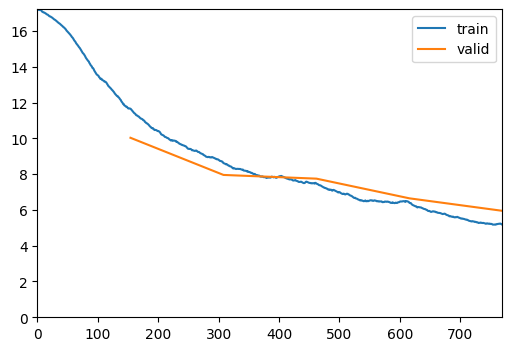

Better model found at epoch 1 with valid_loss value: 7.956538677215576.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-1_1.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-1_1
Better model found at epoch 2 with valid_loss value: 7.748883247375488.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-1_2.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-1_2
Better model found at epoch 3 with valid_loss value: 6.6480937004089355.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-1_3.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-1_3
Better model found at epoch 4 with valid_loss value: 5.949619293212891.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-1_4.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-1_4
convnext_base.fb_in22k_ft_in1k-stage0-2|b=0.2,warmup=0,patience=5,frozen=True
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,5.512296,5.668008,0.880536,02:05
1,4.116379,5.017879,0.885734,02:04
2,3.336316,4.667226,0.893281,02:04
3,2.952877,4.591879,0.894424,02:05
4,2.492879,4.436337,0.898514,02:04


Better model found at epoch 0 with valid_loss value: 5.668007850646973.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-2_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-2_0


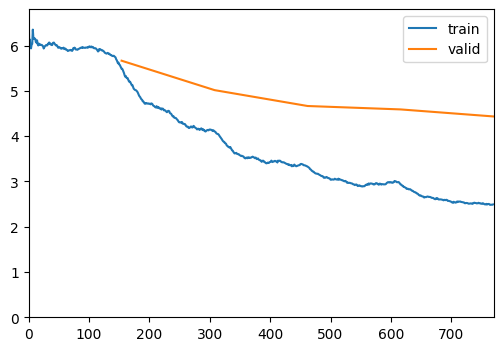

Better model found at epoch 1 with valid_loss value: 5.017879009246826.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-2_1.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-2_1
Better model found at epoch 2 with valid_loss value: 4.667226314544678.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-2_2.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-2_2
Better model found at epoch 3 with valid_loss value: 4.591879367828369.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-2_3.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-2_3
Better model found at epoch 4 with valid_loss value: 4.436336517333984.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-2_4.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-2_4
convnext_base.fb_in22k_ft_in1k-stage0-3|b=0.3,warmup=0,patience=5,frozen=True
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,2.606244,5.285999,0.884282,02:04
1,2.858600,4.831479,0.892265,02:03
2,2.714612,4.647781,0.894088,02:02
3,2.365532,4.775252,0.893012,02:02
4,1.973898,4.178134,0.905596,02:02


Better model found at epoch 0 with valid_loss value: 5.285998821258545.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-3_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-3_0


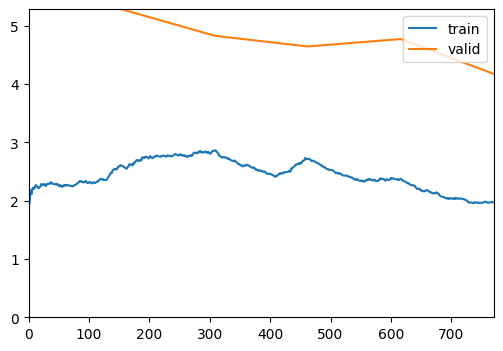

Better model found at epoch 1 with valid_loss value: 4.831479072570801.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-3_1.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-3_1
Better model found at epoch 2 with valid_loss value: 4.6477813720703125.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-3_2.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-3_2
Better model found at epoch 4 with valid_loss value: 4.178133964538574.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-3_4.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-3_4
convnext_base.fb_in22k_ft_in1k-stage0-4|b=0.5,warmup=0,patience=5,frozen=True
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,1.850906,4.612581,0.898130,02:02
1,1.836089,4.332787,0.904197,02:02
2,1.631066,4.201413,0.907076,02:02
3,1.550331,4.490535,0.901110,02:02
4,1.405098,4.279141,0.905710,02:02


Better model found at epoch 0 with valid_loss value: 4.612581253051758.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-4_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-4_0


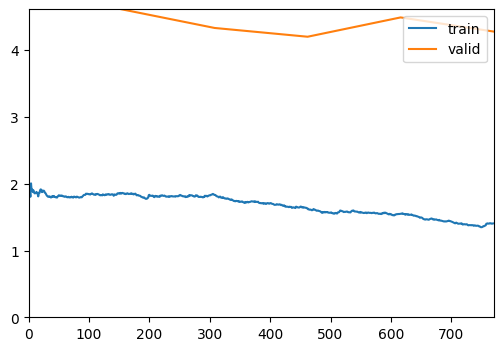

Better model found at epoch 1 with valid_loss value: 4.332787036895752.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-4_1.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-4_1
Better model found at epoch 2 with valid_loss value: 4.201413154602051.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-4_2.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-4_2
convnext_base.fb_in22k_ft_in1k-stage0-5|b=0.8,warmup=0,patience=5,frozen=True
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,1.532836,4.230392,0.908300,02:02
1,1.510614,4.269828,0.907311,02:04
2,1.419912,4.293818,0.907049,02:03
3,1.404411,4.288725,0.907069,02:03
4,1.370915,4.302053,0.906867,02:01


Better model found at epoch 0 with valid_loss value: 4.230391979217529.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-5_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-5_0


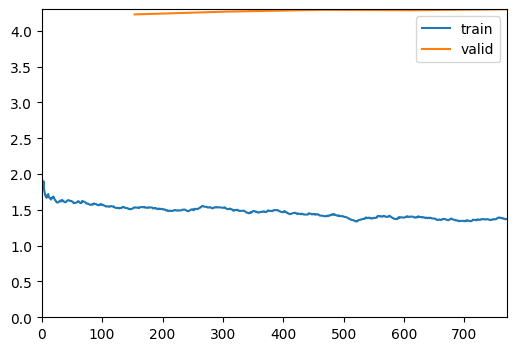

convnext_base.fb_in22k_ft_in1k-stage0-6|b=1.0,warmup=0,patience=5,frozen=True
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,1.543647,4.303893,0.907560,02:01
1,1.563151,4.313430,0.907513,02:01
2,1.508309,4.311643,0.907385,02:02
3,1.493066,4.368434,0.905952,02:01
4,1.449787,4.386189,0.905858,02:03


Better model found at epoch 0 with valid_loss value: 4.303893089294434.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage0-6_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage0-6_0


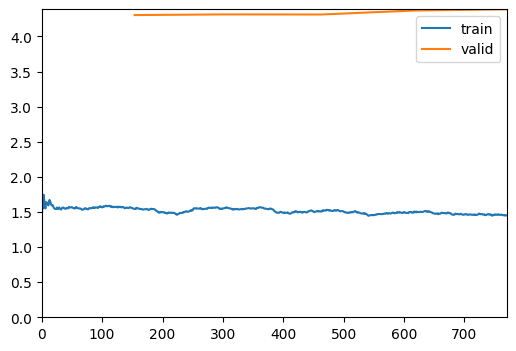

convnext_base.fb_in22k_ft_in1k-stage1|b=1.0,warmup=5,patience=5,frozen=False
 --- LR Find ---


 --- Fit Flat Warmup ---


epoch,train_loss,valid_loss,binary_acc,time
0,1.537485,4.350562,0.906484,02:04


Better model found at epoch 0 with valid_loss value: 4.350561618804932.
Saved Path: models\06-29-2024\convnext_base.fb_in22k_ft_in1k.stage1_0.pth Saved Name: 06-29-2024/convnext_base.fb_in22k_ft_in1k.stage1_0


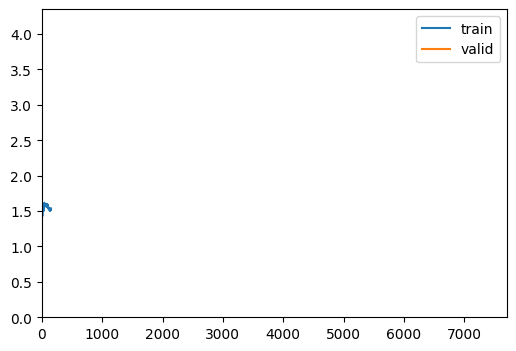

In [7]:
    
df = pd.read_csv("X:\ML\Datasets\koe\labels.csv")
df2 = df.groupby('File', sort=False).apply(np.array, include_groups=False).reset_index()#.apply(np.ravel).reset_index()#

dls = get_dls(df2, bs=mod_cfg.batch_size, ds_options=ds_options)
#print(dls.train_ds[0])
#dls.show_batch(max_n=1)

#output of the base_model will be 4 x 18 x 1024 = 4 x duration*3 x 1024
last_channels = mod_cfg.output_channels

head_def = []

# head_def = [
#     ([3, 3], 1, 1024),
#     ([3, 3], 1, 512),
#     ([3, 3], 1, 256),
#     ([3, 3], 1, 128),
#     #([3, 3], 1, 64),
# ]

c = last_channels
while c >= 128:
    head_def.append(([3, 3], 1, int(c)))
    c = c/2

mod_dict = OrderedDict()
for i in range(len(head_def)):
    l = head_def[i]
    mod_dict[str(i) + '-' + "conv2d_dw"] = nn.Conv2d(kernel_size=l[0], stride=l[1], in_channels=last_channels, out_channels=last_channels, groups=last_channels, padding="same") #depthwise
    mod_dict[str(i) + '-' + "batchnorm_0"] = batch_norm_0 = nn.BatchNorm2d(eps=1e-4, num_features=last_channels)
    mod_dict[str(i) + '-' + "relu_0"] = nn.ReLU()
    mod_dict[str(i) + '-' + "conv2d"] = nn.Conv2d(in_channels=batch_norm_0.num_features, out_channels=l[2],  kernel_size=[1, 1], stride=1, padding="same")
    mod_dict[str(i) + '-' + "batchnorm_1"] = nn.BatchNorm2d(eps=1e-4, num_features=l[2])
    mod_dict[str(i) + '-' + "relu_1"] = nn.ReLU()
    
    last_channels = l[2]

mod_dict["reshape"] = nn.Flatten(start_dim=1, end_dim=2) #reshape 64 x 4 x 18 into 256 x 18
mod_dict["adaptive2dpool"] = nn.AdaptiveAvgPool2d(output_size=(256, ds_options.categories*3))
mod_dict["conv1d"] = nn.Conv1d(256, out_channels=ds_options.time_steps, kernel_size=1)
mod_dict["sigmoid"] = nn.Sigmoid()
custom_head = nn.Sequential(mod_dict)

learn = vision_learner(dls, mod_cfg.name, opt_func=adam(foreach=True), custom_head=custom_head, pretrained=mod_cfg.pretrain, loss_func=YOHOLoss, metrics=[binary_acc], n_in=1, pool=False, concat_pool=False).to_channelslast()

#learn.model
#learn.summary()
#learn.show_results()|

while mod_cfg.can_train():
    mod_cfg.train(learn)